In [16]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import librosa

import sys
sys.path.append('../..')
import libfmp.b
import libfmp.c3
import libfmp.c4
import libfmp.c5
%matplotlib inline

data_basedir = os.path.join('.', 'data', 'dChord')

import torch 
import torch.nn.functional as F
from torchinfo import summary

from copy import deepcopy

## Network configuration

In [17]:
# code copied from libdl.nn_models.cnns_chord_recog

class log_compression(torch.nn.Module):
    """Module for logarithmic compression of an array

    Args:
        gamma: Compression factor
        trainable: Whether the gradient w.r.t. gamma is computed in backward pass
    """
    def __init__(self, gamma_init=1, trainable=True):
        super(log_compression, self).__init__()

        # define logarithm of gamma as trainable parameter
        if gamma_init is not None:
            self.log_gamma = torch.nn.parameter.Parameter(data=torch.log(torch.as_tensor(gamma_init, dtype=torch.float32)), requires_grad=trainable)
        else:
            self.log_gamma = None

    def forward(self, x):
        if self.log_gamma is not None:
            return torch.log(1.0 + torch.exp(self.log_gamma) * x)
        else:
            return x


class gaussian_filter(torch.nn.Module):
    """Module for generating a 1D Gaussian filter

    Args:
        length: kernel length
        sigma: (initial) standard deviation for Gaussian kernel
        dim: dimension across which to apply the filter; output tensor will have singleton dimension at 'dim'
        trainable: whether to optimize the standard deviation
    """
    def __init__(self, length=41, sigma_init=1, dim=2, trainable=True):
        super(gaussian_filter, self).__init__()

        self.length = length
        self.dim = dim

        if sigma_init is None:
            sigma_init = length
        self.log_sigma = torch.nn.parameter.Parameter(data=torch.log(torch.as_tensor(sigma_init, dtype=torch.float32)), requires_grad=trainable)

    def forward(self, x):
        idx = x.ndim * [1]
        idx[self.dim] = self.length
        w = self.get_kernel()
        x_smoothed = torch.sum(x * w.view(*idx), dim=self.dim, keepdim=True)
        return x_smoothed

    def get_kernel(self):
        n = torch.arange(0, self.length).to(self.log_sigma.device) - (self.length - 1.0) / 2.0
        sig2 = 2 * torch.exp(self.log_sigma) ** 2
        w = torch.exp(-n ** 2 / sig2)
        return w / torch.sum(w)


class temporal_smoothing(torch.nn.Module):
    """Module for temporal smoothing of a feature sequence.

    Args:
        smoothing_type: Either 'weighted_sum', 'median' or 'Gaussian'
        avg_length: Length to be averaged over; only relevant for 'weighted_sum' and 'Gaussian' (median is taken over whole input length)
        weight_init: How to initialize (trainable) weights, only relevant for 'weighted_sum' (either 'uniform' or 'random')
    """
    def __init__(self, smoothing_type='weighted_sum', avg_length=41, weight_init='uniform', sigma_init=20):
        super(temporal_smoothing, self).__init__()
        if smoothing_type not in {'weighted_sum', 'median', 'Gaussian'}:
            raise ValueError('Smoothing type ' + smoothing_type + ' is unknown!')

        if weight_init not in {'random', 'uniform'}:
            raise ValueError('Weight initialization ' + weight_init + ' is unknown!')

        self.avg_length = avg_length

        if smoothing_type == 'weighted_sum':
            self.filter = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(avg_length, 1),
                                    stride=(1, 1), bias=False, padding='valid')

            if weight_init == 'random':
                pass
            elif weight_init == 'uniform':
                self.filter.weight.data = torch.ones_like(self.filter.weight.data) / avg_length

        elif smoothing_type == 'median':
            self.filter = lambda x: torch.median(x, dim=2, keepdim=True,).values

        elif smoothing_type == 'Gaussian':
            self.filter = gaussian_filter(length=avg_length, sigma_init=sigma_init, dim=2, trainable=True)

    def forward(self, x):
        # treat channels as batch dimension to use conv. layer with 1 channel
        x_reshaped = x.view(-1, 1, *x.shape[2:])
        x_filtered = self.filter(x_reshaped)
        return x_filtered.view(*x.shape[:2], *x_filtered.shape[2:])


class feature_normalization(torch.nn.Module):
    """Module for feature normalization

    Args:
        num_features: Number of features
        norm: The norm to be applied. '1', '2', 'max' or 'z'
        threshold: Threshold below which the vector `v` is used instead of normalization
        v: Used instead of normalization below `threshold`. If None, uses unit vector for given norm
    """
    def __init__(self, num_features=12, norm='2', threshold=1e-4, v=None, dim=3):
        super(feature_normalization, self).__init__()
        if norm not in ['1', '2', 'max', 'z']:
            raise ValueError('Norm ' + norm + ' is unknown!')

        self.threshold = threshold
        self.v = v

        if norm == '1':
            if self.v is None:
                self.v = torch.ones(num_features, dtype=torch.float32) / num_features
            self.get_norms = lambda x: torch.linalg.vector_norm(x, ord=1.0, dim=dim, keepdim=False)
            self.normalize = lambda x: F.normalize(x, p=1.0, dim=dim, eps=threshold)

        if norm == '2':
            if self.v is None:
                self.v = torch.ones(num_features, dtype=torch.float32) / torch.sqrt(torch.tensor([num_features]))
            self.get_norms = lambda x: torch.linalg.vector_norm(x, ord=2.0, dim=dim, keepdim=False)
            self.normalize = lambda x: F.normalize(x, p=2.0, dim=dim, eps=threshold)

        if norm == 'max':
            if self.v is None:
                self.v = torch.ones(num_features, dtype=torch.float32)
            self.get_norms = lambda x: torch.linalg.vector_norm(x, ord=float('inf'), dim=dim, keepdim=False)
            self.normalize = lambda x: F.normalize(x, p=float('inf'), dim=dim, eps=threshold)

        if norm == 'z':
            if self.v is None:
                self.v = torch.zeros(num_features)
            self.get_norms = lambda x: torch.std(x, dim=dim, keepdim=False, unbiased=True)
            self.normalize = lambda x: (x - torch.mean(x, dim=dim, keepdim=True)) / torch.std(x, dim=dim, keepdim=True,
                                                                                              unbiased=True)
    def forward(self, x):
        x_norms = self.get_norms(x)
        idx = x_norms > self.threshold
        x_normalized = x.clone()
        x_normalized = self.normalize(x_normalized)
        x_normalized[~idx] = self.v.to(x.device)
        return x_normalized


class chord_recognition_templates(torch.nn.Module):
    """Module for applying template-based chord recognition to chroma features.

    Args:
        shared_weights: Whether to use 2 shared kernels (maj/min) or 24 individual chord templates
        initialize_parameters: Whether to initialize kernels with idealized binary chord templates and zero bias
        normalize_weights: Whether to normalize all templates to unit Euclidean norm
        bias: Whether to allow for a trainable bias
    """
    def __init__(self, shared_weights=True, initialize_parameters=True, normalize_weights=True, bias=False):
        super(chord_recognition_templates, self).__init__()
        self.include_blank = include_blank

        if shared_weights:
            self.padding = lambda x: F.pad(x, pad=(0, 11, 0, 0), mode='circular')
            self.filter = torch.nn.Conv2d(in_channels=1, out_channels=3 if include_blank else 2, kernel_size=(1, 12), stride=(1, 1), bias=bias)
            if initialize_parameters:
                self.filter.weight.data = torch.zeros_like(self.filter.weight.data)
                self.filter.weight.data[0, 0, 0, :] = torch.tensor([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=torch.float32) # major
                self.filter.weight.data[1, 0, 0, :] = torch.tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], dtype=torch.float32) # minor
                # self.filter.weight.data = torch.tensor([[[[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]]],     # major
                #                                         [[[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]]]],    # minor
                                                       # dtype=torch.float32)
                if include_blank:
                    self.filter.weight.data[2, 0, 0, :] = torch.ones(12)/12
                if self.filter.bias is not None:
                    self.filter.bias.data = torch.zeros_like(self.filter.bias.data, dtype=torch.float32)

        else:
            self.padding = lambda x: x
            self.filter = torch.nn.Conv2d(in_channels=1, out_channels=25 if include_blank else 24, kernel_size=(1, 12), stride=(1, 1), bias=bias)
            if initialize_parameters:
                kernel_major = torch.tensor([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0])
                kernel_minor = torch.tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])

                for i in range(12):
                    self.filter.weight.data[i, 0, 0, :] = torch.roll(kernel_major, i)
                    self.filter.weight.data[12 + i, 0, 0, :] = torch.roll(kernel_minor, i)
                if include_blank:
                    self.filter.weight.data[24, 0, 0, :] = torch.ones(12) / 12

                if self.filter.bias is not None:
                    self.filter.bias.data = torch.zeros_like(self.filter.bias.data, dtype=torch.float32)

        if normalize_weights:
            self.filter.weight.data = F.normalize(self.filter.weight.data, p=2.0, dim=3)

    def forward(self, x):
        x_padded = self.padding(x)                                          # out: (B x 1 x T x 23) or (B x 1 x T x 12)
        y = self.filter(x_padded)                                           # out: (B x 3 x T x 12) or (B x 25 x T x 1)
        if self.include_blank and shared_weights:
            blank_channel = y[:, 2:3, :, :]
            y = y[:, :2, :, :]
            y_reshaped = torch.swapaxes(y, 1, 2)                            # out: (B x T x 2 x 12)
            y_reshaped = torch.flatten(y_reshaped, start_dim=2)             # out: (B x T x 24)
            blank_replicaed = blank_channel.squeeze(1).repeat(1, 1, 1, 12)  # out: (B x T x 1 x 12)
            blank_flatten = torch.flatten(blank_replicaed, start_dim=2)     # out: (B x T x 12)
            y_reshaped = torch.cat([y_reshaped, blank_flatened], dim=2)     # out: (B x T x 25)
            y_reshaped = torch.unsqueeze(y_reshaped, 1)                     # out: (B x 1 x T x 25)
        else:
            y_reshaped = torch.swapaxes(y, 1, 2)                                # out: (B x T x 2 x 12) or (B x T x 24 x 1)
            y_reshaped = torch.unsqueeze(torch.flatten(y_reshaped, start_dim=2), 1)             # out: (B x 1 x T x 24)
        return y_reshaped


class softmax_temperature(torch.nn.Module):
    """Softmax activation with trainable temperature parameter

    Args:
        dim: Dimension across which to apply the softmax function
        tau: Temperature parameter
        trainable: Whether the gradient w.r.t. tau is computed in backward pass
    """
    def __init__(self, dim=3, tau=1, trainable=True):
        super(softmax_temperature, self).__init__()
        self.dim = dim
        self.tau = torch.nn.parameter.Parameter(data=torch.tensor([tau], dtype=torch.float32), requires_grad=trainable)

    def forward(self, x):
        return F.softmax(x / self.tau, dim=self.dim)


class chord_recog_templates_pipeline(torch.nn.Module):
    """Model for template-based chord recognition:

    Pipeline:
        1) input: chroma features
        2) log compression (gamma trainable)
        3) temporal averaging (conv. layer with trainable weights / median filter / Gaussian filter)
        4) l1/l2/max/z normalization (only if norm large enough; otherwise: unit-norm vector with same values)
        5) chord recognition via templates (conv. layer)
        6) softmax -> output: chord probabilities

    Args:
        dictionaries containing parameters for the individual building blocks
    """
    def __init__(self, compression_params=None, temp_smooth_params=None, feature_norm_params=None,
                 chord_template_params=None, softmax_params=None):

        super(chord_recog_templates_pipeline, self).__init__()

        self.log_compression = log_compression(**compression_params)
        self.temporal_smoothing = temporal_smoothing(**temp_smooth_params)
        self.feature_normalization = feature_normalization(**feature_norm_params)
        self.chord_recognition_templates = chord_recognition_templates(**chord_template_params)
        self.softmax_temperature = softmax_temperature(**softmax_params)

    def forward(self, x):
        y_pred, _, _, _, _ = self.get_intermediate_data(x)
        return y_pred

    def get_intermediate_data(self, x):
        x_comp = self.log_compression(x)                                    # out: (B x 1 x T x 12)
        x_avg = self.temporal_smoothing(x_comp)                             # out: (B x 1 x 1 x 12)
        x_normalized = self.feature_normalization(x_avg)                    # out: (B x 1 x 1 x 12)
        x_templates = self.chord_recognition_templates(x_normalized)        # out: (B x 1 x 1 x 24)
        y_pred = self.softmax_temperature(x_templates)                      # out: (B x 1 x 1 x 24)
        return y_pred, x_templates, x_normalized, x_avg, x_comp

In [18]:
# Pipeline config

compression_params = {'gamma_init': 1.0,       # makes pipeline somehow redundant; input chroma features are already logarithmically compressed
                      'trainable': True}

temp_smooth_params = {'smoothing_type': 'weighted_sum', 
                      'avg_length': 51, 
                      'weight_init': 'uniform'}

# temp_smooth_params = {'smoothing_type': 'Gaussian', 
#                       'avg_length': 51, 
#                       'sigma_init': 50}

feature_norm_params = {'num_features': 12,
                       'norm': '2', 
                       'threshold': 1e-4}

chord_template_params = {'shared_weights': True, 
                         'initialize_parameters': True, 
                         'normalize_weights': False}

softmax_params = {'tau': 1, 
                  'trainable': False}

model_pipeline = chord_recog_templates_pipeline(compression_params=compression_params, 
                                       temp_smooth_params=temp_smooth_params, 
                                       feature_norm_params=feature_norm_params, 
                                       chord_template_params=chord_template_params, 
                                       softmax_params=softmax_params)

In [19]:
summary(model_pipeline, input_size=(1, 1, temp_smooth_params['avg_length'], 12))

Layer (type:depth-idx)                   Output Shape              Param #
chord_recog_templates_pipeline           [1, 1, 1, 24]             --
├─log_compression: 1-1                   [1, 1, 51, 12]            1
├─temporal_smoothing: 1-2                [1, 1, 1, 12]             --
│    └─Conv2d: 2-1                       [1, 1, 1, 12]             51
├─feature_normalization: 1-3             [1, 1, 1, 12]             --
├─chord_recognition_templates: 1-4       [1, 1, 1, 24]             --
│    └─Conv2d: 2-2                       [1, 2, 1, 12]             24
├─softmax_temperature: 1-5               [1, 1, 1, 24]             (1)
Total params: 77
Trainable params: 76
Non-trainable params: 1
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

## The END of network configuration
## -------------------------------------------------------------------------------------------------------

## Prepare data

In [20]:
nonchord = False
song_dict = {}
# song_dict[0] = ['LetItB', 'r',
#                 os.path.join(data_basedir, 'C5', 'FMP_C5_Audio_Beatles_LetItBe_Beatles_1970-LetItBe-06.wav'),
#                 os.path.join(data_basedir, 'C5', 'FMP_C5_Audio_Beatles_LetItBe_Beatles_1970-LetItBe-06_Chords_simplified.csv')]
song_dict[0] = ['LetItB', 'r',
                os.path.join(data_basedir, 'FMP_C5_F01_Beatles_LetItBe-mm1-4_Original.wav'),
                os.path.join(data_basedir, 'FMP_C5_F01_Beatles_LetItBe-mm1-4_Original_Chords_simplified.csv')]
song_dict[1] = ['HereCo', 'b',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07_Chords_simplified.csv')]
song_dict[2] = ['ObLaDi', 'c',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04_Chords_simplified.csv')]
song_dict[3] = ['PennyL', 'g',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09_Chords_simplified.csv')]

# csv_rel_path = song_dict[0][3]
# csv_abs_path = os.path.abspath(csv_rel_path)
# print(csv_abs_path)

### Feature Extraction (log-compressed STFT-based chroma features as above)

In [21]:
def compute_X_dict(song_selected, version='STFT', details=True, nonchord=False):
    X_dict = {}
    Fs_X_dict = {}
    ann_dict = {}
    x_dur_dict = {}
    chord_labels = libfmp.c5.get_chord_labels(ext_minor='m', nonchord=nonchord)
    for s in song_selected:
        if details is True:
            print('Processing: ', song_dict[s][0])
        fn_wav = song_dict[s][2]
        fn_ann = song_dict[s][3]
#         N = 2048
#         H = 1024
        N = 4096
        H = 2048
        if version == 'STFT':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')            # no log compression
        if version == 'CQT':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, H=H, version='CQT')                  # no log compression
        if version == 'IIR':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=10, version='IIR')             # no log compression
            
        X_dict[s] = X
        Fs_X_dict[s] = Fs_X
        x_dur_dict[s] = x_dur
        N_X = X.shape[1]
        
        # one-hot encoding, converts chord label (.csv file) to label matrix
        ann_dict[s] = libfmp.c5.convert_chord_ann_matrix(fn_ann, chord_labels, Fs=Fs_X, N=N_X, last=False)   
        
    return X_dict, Fs_X_dict, ann_dict, x_dur_dict, chord_labels
    
song_selected = [0, 1, 2, 3]
#song_selected = [0]
print('===== Computation of STFT-based chromagrams =====')
X_dict_STFT, Fs_X_dict_STFT, ann_dict_STFT, x_dur_dict, chord_labels = compute_X_dict(song_selected, version='STFT', nonchord=nonchord)

===== Computation of STFT-based chromagrams =====
Processing:  LetItB
Processing:  HereCo
Processing:  ObLaDi
Processing:  PennyL


### Create Dataset + Dataloader

In [24]:
class dataset_context(torch.utils.data.Dataset):
    def __init__(self, inputs, targets, params):
        self.inputs = inputs                                # Channels x Time x Chromas
        self.targets = targets                              # Time x Chords
        self.context = params['context']
        self.stride = params['stride']
        
    def __len__(self):
        return (self.inputs.size()[1] - self.context) // self.stride
    
    def __getitem__(self, index):
        index *= self.stride
        half_context = self.context // 2
        index += half_context
        X = self.inputs[:, (index - half_context):(index + half_context + 1), :].type(torch.FloatTensor)
        # y is the training target(this is strongly aligned label)
        y = torch.unsqueeze(torch.unsqueeze(self.targets[index, :], 0), 1).type(torch.FloatTensor)
        return X, y
    
def create_dataset(data_dict, ann_dict, song_dict, song_indices, dataset_params, dataset_description='train'):
    all_datasets = []
    half_context = dataset_params['context']//2
    
    for s in song_indices:
        inputs = torch.unsqueeze(torch.from_numpy(np.pad(data_dict[s].T, ((half_context, half_context + 1), (0, 0)))), 0)
        print(ann_dict[s][0])
        # transpose and zero-padding the label matrix
        targets = torch.from_numpy(np.pad(ann_dict[s][0].T, ((half_context, half_context + 1), (0, 0))))
        curr_dataset = dataset_context(inputs, targets, dataset_params)
        all_datasets.append(curr_dataset)
        
        print(f'- {song_dict[s][0]} added to {dataset_description} set. Length: {len(curr_dataset)} segments')
        
    full_dataset = torch.utils.data.ConcatDataset(all_datasets)     
    print(f'Total number of segments in the {dataset_description} set: {len(full_dataset)}')    
    return full_dataset

def create_CTC_dataset(data_dict, ann_dict, song_dict, song_indices, dataset_params, dataset_description='train'):
    all_datasets = []
    half_context = dataset_params['context']//2
    
    for s in song_indices:
        inputs = torch.unsqueeze(torch.from_numpy(np.pad(data_dict[s].T, ((half_context, half_context + 1), (0, 0)))), 0)
        print(ann_dict[s][0])
        # transpose and zero-padding the label matrix
        targets = torch.from_numpy(np.pad(ann_dict[s][0].T, ((half_context, half_context + 1), (0, 0))))
        label_sequence = torch.argmax(targets, dim=1)
        ctc_targets = [label_sequence[0]]
        for i in range(1, len(label_sequence)):
            if label_sequence != label_sequence[i-1]:
                ctc_targets.append(label_sequence[i])
        ctc_targets = torch.tensor(ctc_targets)
        target_lengths = torch.tensor([len(ctc_targets)])
        curr_dataset = dataset_context(inputs, ctc_targets, dataset_params)
        all_datasets.append(curr_dataset)
        
        print(f'- {song_dict[s][0]} added to {dataset_description} set. Length: {len(curr_dataset)} segments')
        
    full_dataset = torch.utils.data.ConcatDataset(all_datasets)     
    print(f'Total number of segments in the {dataset_description} set: {len(full_dataset)}')    
    return full_dataset

In [25]:
train_set_indices = [1, 2]
train_set_params = {'context': temp_smooth_params['avg_length'], 'stride': 1}

train_set = create_dataset(data_dict=X_dict_STFT, 
                           ann_dict=ann_dict_STFT, 
                           song_dict=song_dict, 
                           song_indices=train_set_indices, 
                           dataset_params=train_set_params, 
                           dataset_description='train')

print('\n')

val_set_indices = [3]
val_set_params = {'context': temp_smooth_params['avg_length'], 'stride': 1}

val_set = create_dataset(data_dict=X_dict_STFT, 
                         ann_dict=ann_dict_STFT, 
                         song_dict=song_dict, 
                         song_indices=val_set_indices, 
                         dataset_params=val_set_params, 
                         dataset_description='val')
print('\n')
train_loader_params = {'batch_size': 50, 'shuffle': True, 'num_workers': 0}
train_loader = torch.utils.data.DataLoader(train_set, **train_loader_params)
print(f'-Training data loader contains {len(train_loader)} mini batches.')

val_loader_params = {'batch_size': 50, 'shuffle': False, 'num_workers': 0}
val_loader = torch.utils.data.DataLoader(val_set, **val_loader_params)
print(f'-Validation data loader contains {len(val_loader)} mini batches.')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
- HereCo added to train set. Length: 1999 segments
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
- ObLaDi added to train set. Length: 2034 segments
Total number of segments in the train set: 4033


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
- PennyL added to val set. Length: 1975 segments
Total number of segments in the val set: 1975


-Training data loader contains 81 mini batches.
-Validation data loader contains 40 mini batches.


## Train Pipeline

In [26]:
print('Trainable parameters:\n')

trainable_parameters = []
for name, param in model_pipeline.named_parameters():
    if param.requires_grad:
        trainable_parameters.append(name)
        print(f"'{name}'") 

Trainable parameters:

'log_compression.log_gamma'
'temporal_smoothing.filter.weight'
'chord_recognition_templates.filter.weight'


In [27]:
optimization_mode = 0

if optimization_mode == 1:
    frozen_parameters = []           

if optimization_mode == 2:
    trained_parameters = []
if optimization_mode == 0:
    parameters_to_optimize = model_pipeline.parameters()
    
elif optimization_mode == 1:
    parameters_to_optimize = []

    for name, param in model_pipeline.named_parameters():
        if not name in frozen_parameters:
            parameters_to_optimize.append(param)
            
elif optimization_mode == 2:
    parameters_to_optimize = []

    for name, param in model_pipeline.named_parameters():
        if name in trained_parameters:
            parameters_to_optimize.append(param)

### Optimizer&Training params

In [28]:
optim_params = {'lr': 0.01, 'betas': (0.9, 0.999)}
optimizer = torch.optim.Adam(parameters_to_optimize, **optim_params)
training_params = {'device': 'cpu', 'max_epochs': 50}
# training_params = {'device': 'cuda:0', 'max_epochs': 25}

# CTC LOSS

In [35]:
def ctc_loss_fn(log_probs, targets, input_lengths, target_lengths):
    return F.ctc_loss(
        log_probs=log_probs,
        targets=targets,
        input_lengths=input_lengths,
        target_lengths=target_lengths,
        blank=0,                 # 0 as blank index
        reduction='mean',
        zero_infinity=True
    )

### Network Training - Train the model

In [36]:
model_pipeline = model_pipeline.to(training_params['device'])

best_model = deepcopy(model_pipeline)
best_val_loss = None
best_epoch = None

train_losses = []
val_losses = []

for epoch in range(training_params['max_epochs']):
    model_pipeline.train()

    with torch.enable_grad():
        accum_loss, n_batches = 0, 0
        for X, y in train_loader:
            X, y = X.to(training_params['device']), y.to(training_params['device'])

            y_pred = model_pipeline(X)                       # [B, 1, T, 24]
            logits = logits.squeeze(1)                       # [B, T, 24]
            log_probs = logits.log_softmax(dim=2)            # [B, T, 24]
            log_probs = log_probs.permute(1, 0, 2)           # [T, B, 24]

            # Convert one-hot targets to class indices
            target_classes = torch.argmax(y.squeeze(1).squeeze(1), dim=1)  # [B]
            targets = target_classes

            input_lengths = torch.full(
                size=(log_probs.size(1),), fill_value=log_probs.size(0), dtype=torch.long
            )
            target_lengths = torch.ones(log_probs.size(1), dtype=torch.long)

            loss = ctc_loss_fn(log_probs, targets, input_lengths, target_lengths)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            accum_loss += loss.item()
            n_batches += 1

    model_pipeline.eval()

    with torch.no_grad():
        accum_loss_val, n_batches_val = 0, 0
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(training_params['device']), y_val.to(training_params['device'])

            logits_val = model_pipeline(X_val)                       # [B, 1, T, 24]
            logits_val = logits_val.squeeze(1)                       # [B, T, 24]
            log_probs_val = logits_val.log_softmax(dim=2)            # [B, T, 24]
            log_probs_val = log_probs_val.permute(1, 0, 2)           # [T, B, 24]

            target_classes_val = torch.argmax(y_val.squeeze(1).squeeze(1), dim=1)  # [B]
            targets_val = target_classes_val

            input_lengths_val = torch.full(
                size=(log_probs_val.size(1),), fill_value=log_probs_val.size(0), dtype=torch.long
            )
            target_lengths_val = torch.ones(log_probs_val.size(1), dtype=torch.long)

            loss_val = ctc_loss_fn(log_probs_val, targets_val, input_lengths_val, target_lengths_val)

            accum_loss_val += loss_val.item()
            n_batches_val += 1

    train_loss = accum_loss / n_batches
    val_loss = accum_loss_val / n_batches_val
    print(f'Finished epoch {epoch}. Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model_pipeline)
        best_epoch = epoch
        print('    ...saved model')

    train_losses.append(train_loss)
    val_losses.append(val_loss)

model_pipeline = deepcopy(best_model)
print(f'\nRestored model from epoch {best_epoch}.')

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

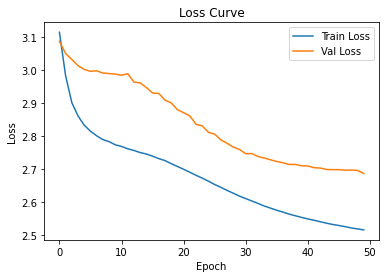

In [31]:
if len(train_losses) > 1:
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

### Test